In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from scipy.stats import reciprocal

In [2]:
df = pd.read_csv(r"Churn_Modelling.csv.xls")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Before machine learning modelling, i perform data cleaning, feature engineering, and visualization to prepare the data for modeling and to gain insights into the dataset and transform it into a suitable format for building predictive models.

In [3]:
# removing the irrelevant columns
cols_to_drop = ["RowNumber","CustomerId","Surname"]
df = df.drop(columns=cols_to_drop,axis=1)
# first five rows of dataframe after removing columns
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# identify numerical columns in the DataFrame
numerical_columns = [col for col in df.columns if (df[col].dtype=='int64' or df[col].dtype=='float64') and col != 'Exited']
numerical_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [5]:
# some descriptive statistic informations about numerical columns
df[numerical_columns].describe().loc[['min','max', 'mean','50%'],:]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
min,350.0000,18.0000,0.0000,0.000000,1.0000,0.0000,0.0000,11.580000
max,850.0000,92.0000,10.0000,250898.090000,4.0000,1.0000,1.0000,199992.480000
mean,650.5288,38.9218,5.0128,76485.889288,1.5302,0.7055,0.5151,100090.239881
50%,652.0000,37.0000,5.0000,97198.540000,1.0000,1.0000,1.0000,100193.915000


In [6]:
df[df['EstimatedSalary'] == df['EstimatedSalary'].min()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2362,709,Germany,Male,45,4,122917.71,1,1,1,11.58,1


In [7]:
# the percentage of customers who have exited (churned) based on gender.
percentages = []
for gen in list(df["Gender"].unique()):

    p = round((df["Exited"][df["Gender"]==gen].value_counts()[1]/df["Exited"][df["Gender"]==gen].value_counts().sum())*100 , 2)

    percentages.append(p)
    print(gen,"(% to exit) : ", p)

Female (% to exit) :  25.07
Male (% to exit) :  16.46


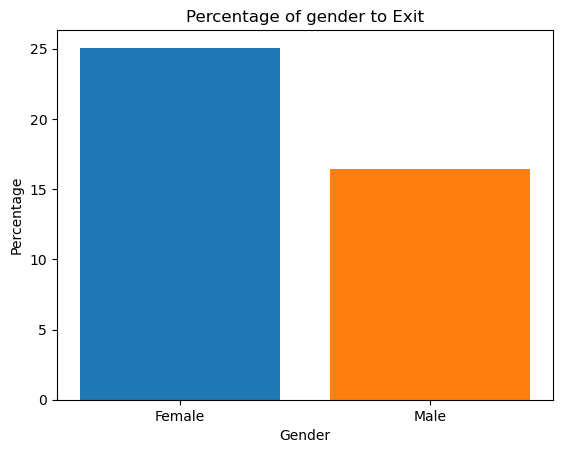

In [8]:
plt.bar(0, percentages[0])
plt.bar(1, percentages[1])
plt.xticks((0,1), ('Female','Male'))
plt.xlabel("Gender")
plt.ylabel("Percentage")
plt.title("Percentage of gender to Exit")
plt.show()

In [9]:
# the percentage of customers who have exited based on geography

percentages = []
for country in list(df["Geography"].unique()):

    p = round((df["Exited"][df["Geography"]==country].value_counts()[1]/df["Exited"][df["Geography"]==country].value_counts().sum())*100 , 2)

    percentages.append(p)
    print(country,"(% to exit) : ", p)

France (% to exit) :  16.15
Spain (% to exit) :  16.67
Germany (% to exit) :  32.44


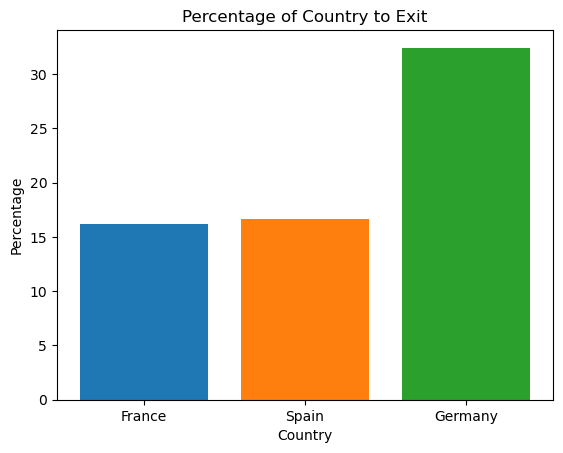

In [10]:
for i in range(len(percentages)):
    plt.bar(i, percentages[i])
plt.xticks((0,1,2), ('France', 'Spain', 'Germany'))
plt.xlabel("Country")
plt.ylabel("Percentage")
plt.title("Percentage of Country to Exit")
plt.show()

Text(0, 0.5, 'Frequency')

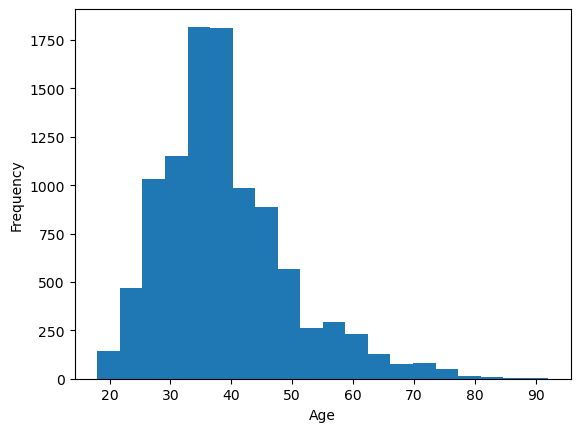

In [12]:
# the age distribution
plt.hist(df["Age"],bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")

Text(0.5, 1.0, 'People who did not Exit (Exited = 0)')

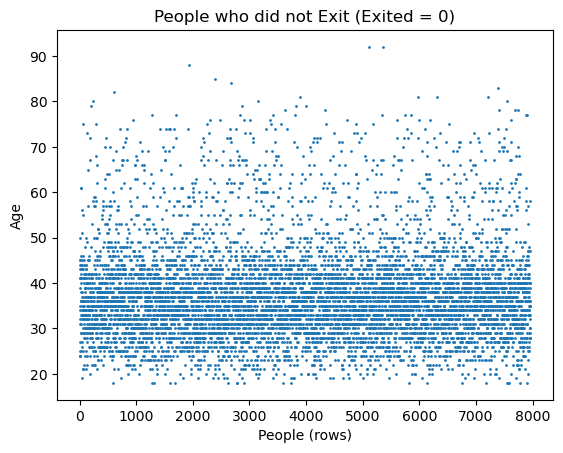

In [13]:
plt.scatter(x=range(len(list(df["Age"][df["Exited"]==0]))),y=df["Age"][df["Exited"]==0],s=1)
plt.ylabel("Age")
plt.xlabel("People (rows)")
plt.title("People who did not Exit (Exited = 0)")

Text(0.5, 1.0, 'People who Exited (Exited = 1)')

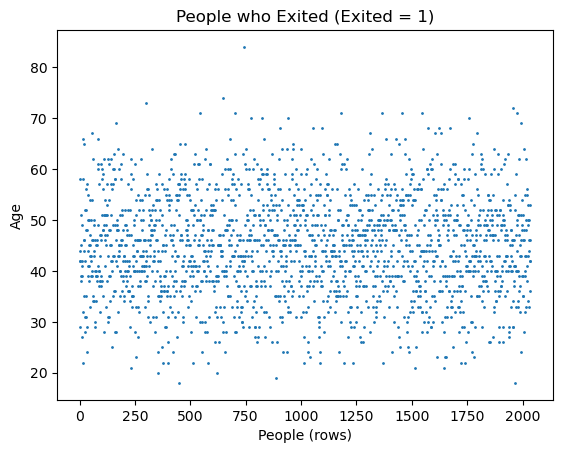

In [14]:
plt.scatter(x=range(len(list(df["Age"][df["Exited"]==1]))),y=df["Age"][df["Exited"]==1],s=1)
plt.ylabel("Age")
plt.xlabel("People (rows)")
plt.title("People who Exited (Exited = 1)")

In [15]:
age_bucket = df.groupby(pd.cut(df["Age"],bins=[10,20,30,40,50,60,70,80,90,100]))
age_bucket = round((age_bucket.sum()["Exited"] / age_bucket.size())*100 , 2)
age_bucket

Age
(10, 20]      5.62
(20, 30]      7.61
(30, 40]     12.09
(40, 50]     33.97
(50, 60]     56.21
(60, 70]     31.42
(70, 80]      8.26
(80, 90]     10.00
(90, 100]     0.00
dtype: float64

Text(0.5, 1.0, 'Percentage of people in different Age Groups that exited')

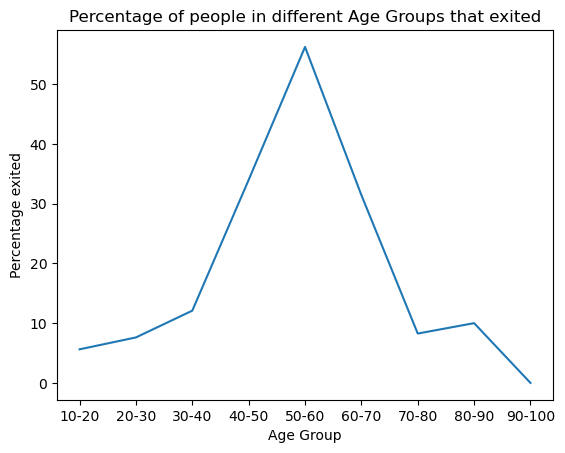

In [16]:
x = [str(i)+"-"+str(i+10) for i in range(10,91,10)]
plt.plot(x,age_bucket.values)
plt.xlabel("Age Group")
plt.ylabel("Percentage exited")
plt.title("Percentage of people in different Age Groups that exited")

In [17]:
# The "Age" column is converted into categorical bins (age groups) using the pd.cut() function
df["Age"] = pd.cut(df["Age"],bins=[10,20,30,40,50,60,70,80,90,100])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,"(40, 50]",2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,"(40, 50]",1,83807.86,1,0,1,112542.58,0
2,502,France,Female,"(40, 50]",8,159660.80,3,1,0,113931.57,1
3,699,France,Female,"(30, 40]",1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,"(40, 50]",2,125510.82,1,1,1,79084.10,0


In [18]:
# performs one-hot encoding on categorical variables in the DataFrame, converting them into numerical representations
df = pd.get_dummies(df)
df.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,...,Gender_Male,"Age_(10, 20]","Age_(20, 30]","Age_(30, 40]","Age_(40, 50]","Age_(50, 60]","Age_(60, 70]","Age_(70, 80]","Age_(80, 90]","Age_(90, 100]"
0,619,2,0.00,1,1,1,101348.88,1,True,False,...,False,False,False,False,True,False,False,False,False,False
1,608,1,83807.86,1,0,1,112542.58,0,False,False,...,False,False,False,False,True,False,False,False,False,False
2,502,8,159660.80,3,1,0,113931.57,1,True,False,...,False,False,False,False,True,False,False,False,False,False
3,699,1,0.00,2,0,0,93826.63,0,True,False,...,False,False,False,True,False,False,False,False,False,False
4,850,2,125510.82,1,1,1,79084.10,0,False,False,...,False,False,False,False,True,False,False,False,False,False


In [19]:
# Drop redundant columns "Geography_France" and "Gender_Female" are dropped
# as they can be derived from the remaining columns due to one-hot encoding.
df = df.drop(columns=["Geography_France","Gender_Female"],axis=1)

In [20]:
# Select features and target variable
df = df.iloc[:,:-1]

In [21]:
# Save the cleaned data
df.to_csv('Clean_data.csv')

In [23]:
df = pd.read_csv('Clean_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10000 non-null  int64  
 1   CreditScore        10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  bool   
 10  Geography_Spain    10000 non-null  bool   
 11  Gender_Male        10000 non-null  bool   
 12  Age_(10, 20]       10000 non-null  bool   
 13  Age_(20, 30]       10000 non-null  bool   
 14  Age_(30, 40]       10000 non-null  bool   
 15  Age_(40, 50]       10000 non-null  bool   
 16  Age_(50, 60]       1000

,Unnamed: 0,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,"Age_(10, 20]","Age_(20, 30]","Age_(30, 40]","Age_(40, 50]","Age_(50, 60]","Age_(60, 70]","Age_(70, 80]","Age_(80, 90]"
0,0,619,2,0.00,1,1,1,101348.88,1,False,False,False,False,False,False,True,False,False,False,False
1,1,608,1,83807.86,1,0,1,112542.58,0,False,True,False,False,False,False,True,False,False,False,False
2,2,502,8,159660.80,3,1,0,113931.57,1,False,False,False,False,False,False,True,False,False,False,False
3,3,699,1,0.00,2,0,0,93826.63,0,False,False,False,False,False,True,False,False,False,False,False
4,4,850,2,125510.82,1,1,1,79084.10,0,False,True,False,False,False,False,True,False,False,False,False


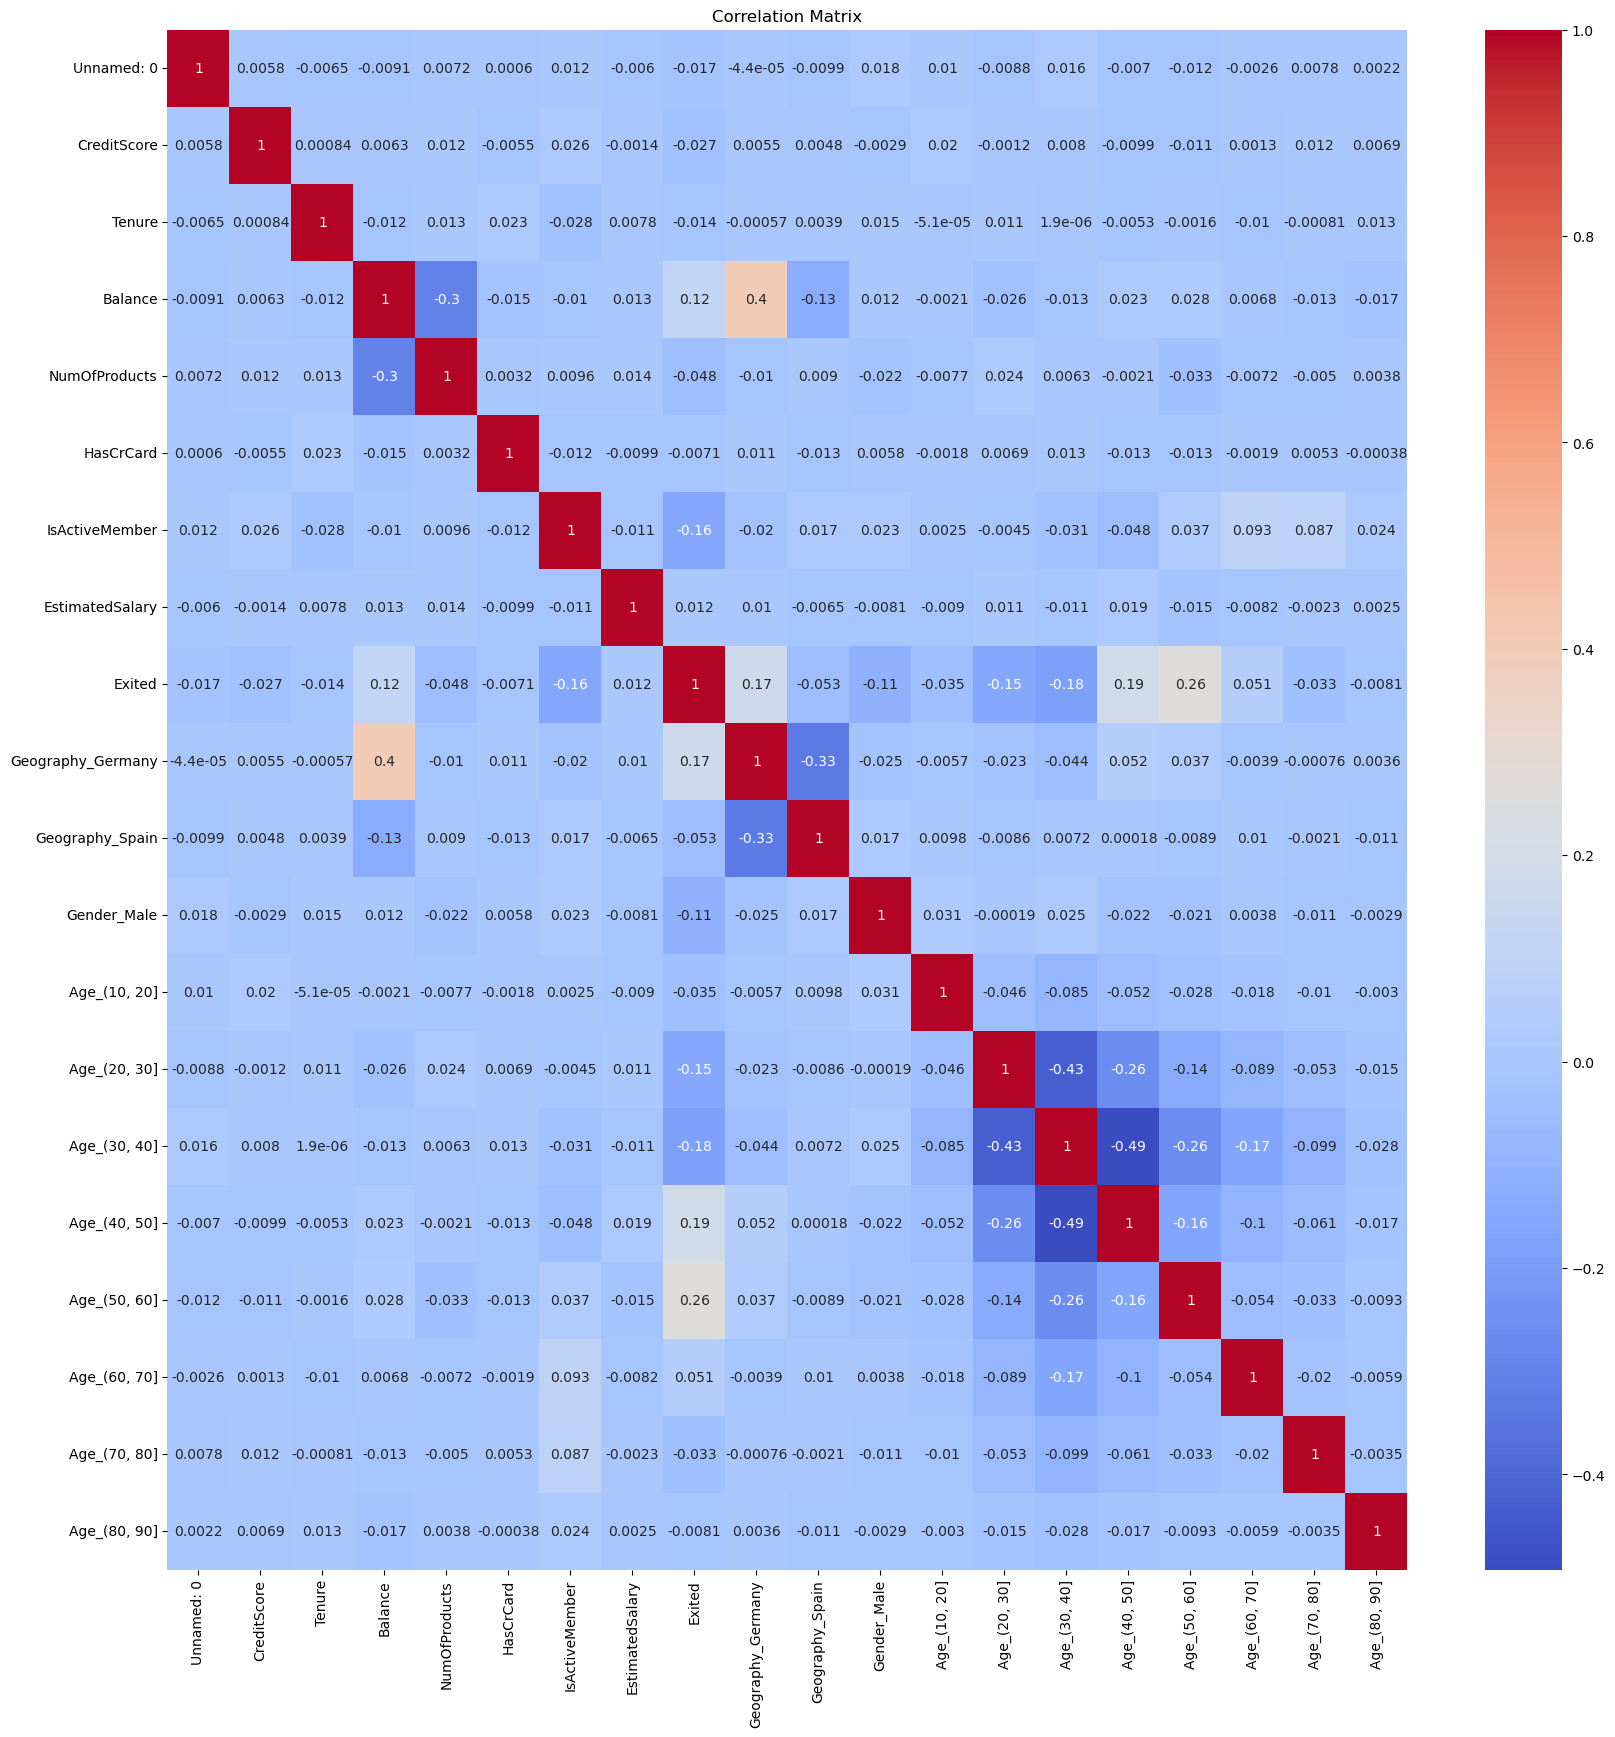

In [24]:
# Data Exploration (additional)
# Perform EDA techniques such as correlation analysis, distribution analysis, etc.
correlation_matrix = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The features do not show strong correlations with each other so it indicates that they are relatively independent or have minimal linear relationships. In such cases, it is generally safe to use all the features for further analysis.

In [25]:
# Model Training and Evaluation
feat = df.drop(columns=['Exited'], axis=1)
label = df["Exited"]
X_train, X_test, y_train, y_test = train_test_split(feat, label, test_size=0.3, random_state=42)

SC = StandardScaler()
X_train = SC.fit_transform(X_train)
X_test = SC.transform(X_test)

Hyperparameter tuning helps in finding the optimal set of hyperparameters for a machine learning model. By searching through different combinations of hyperparameters, RandomizedSearchCV automates this process and identifies the best hyperparameters based on the specified scoring metric and cross-validation. The best model obtained can then be used for further evaluation and prediction tasks.

### Support Vector Classifier

In [28]:
# Define the parameter distribution
param_dist = {
    'C': reciprocal(0.1, 1),
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    scoring='accuracy',
    cv=10,
    n_iter=10,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Parameters: ", best_params)

# Print the best model
print("Best Model: ", best_model)

Best Parameters:  {'C': 0.6413504879514703, 'gamma': 'auto', 'kernel': 'rbf'}
Best Model:  SVC(C=0.6413504879514703, gamma='auto')


In [29]:
# Model Evaluation Metrics for SVC
y_pred_svc = best_model.predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred_svc)
accuracy = accuracy_score(y_test, y_pred_svc)
precision = precision_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
f1 = f1_score(y_test, y_pred_svc)

print("Confusion Matrix (Support Vector Classifier):\n", cm_svc)
print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Precision: ", round(precision * 100, 2), "%")
print("Recall: ", round(recall * 100, 2), "%")
print("F1-Score: ", round(f1 * 100, 2), "%")

Confusion Matrix (Support Vector Classifier):
 [[2360   56]
 [ 362  222]]
Accuracy:  86.07 %
Precision:  79.86 %
Recall:  38.01 %
F1-Score:  51.51 %


### Logistic Regression

In [30]:


# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters: ", best_params)

# Print the best model
print("Best Model: ", best_model)


/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best Model:  LogisticRegression(C=0.1, penalty='l1', solver='saga')


/Users/bernayilmaz/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [31]:
# Model Evaluation Metrics for Logistic Regression
y_pred_lr = best_model.predict(X_test)
cm_logistic_regression = confusion_matrix(y_test, y_pred_lr)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Confusion Matrix (Logistic Regression):\n", cm_logistic_regression)
print("Accuracy (Logistic Regression): ", round(accuracy_lr * 100, 2), "%")
print("Precision (Logistic Regression): ", round(precision_lr * 100, 2), "%")
print("Recall (Logistic Regression): ", round(recall_lr * 100, 2), "%")
print("F1-Score (Logistic Regression): ", round(f1_lr * 100, 2), "%")

Confusion Matrix (Logistic Regression):
 [[2328   88]
 [ 402  182]]
Accuracy (Logistic Regression):  83.67 %
Precision (Logistic Regression):  67.41 %
Recall (Logistic Regression):  31.16 %
F1-Score (Logistic Regression):  42.62 %


### Random Forest Classifier

In [32]:


# Create the Random Forest Classifier object
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best model for Random Forest
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

# Print the best parameters for Random Forest
print("Best Parameters for Random Forest: ", best_params_rf)

# Print the best model for Random Forest
print("Best Model for Random Forest: ", best_model_rf)



Best Parameters for Random Forest:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Model for Random Forest:  RandomForestClassifier(min_samples_split=10, n_estimators=200, random_state=42)


In [33]:
# Model Evaluation Metrics for Random Forest Classifier
y_pred_rf = best_model_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Confusion Matrix (Random Forest Classifier):\n", cm_rf)
print("Accuracy (Random Forest Classifier): ", round(accuracy_rf * 100, 2), "%")
print("Precision (Random Forest Classifier): ", round(precision_rf * 100, 2), "%")
print("Recall (Random Forest Classifier): ", round(recall_rf * 100, 2), "%")
print("F1-Score (Random Forest Classifier): ", round(f1_rf * 100, 2), "%")

Confusion Matrix (Random Forest Classifier):
 [[2338   78]
 [ 329  255]]
Accuracy (Random Forest Classifier):  86.43 %
Precision (Random Forest Classifier):  76.58 %
Recall (Random Forest Classifier):  43.66 %
F1-Score (Random Forest Classifier):  55.62 %


### Comparison

Based on these performance metrics:

The Random Forest Classifier outperforms both SVC and Logistic Regression in terms of accuracy, precision, recall, and F1-score. It has the highest accuracy (86.43%) among the three models.

The Support Vector Classifier (SVC) has the highest precision (79.86%), which means it is better at correctly predicting the positive class (Exited=1) when it makes a positive prediction.

The Random Forest Classifier has the highest recall (43.66%), indicating it can identify more of the actual positive samples (churned customers) compared to the other models.

The Random Forest Classifier also has the highest F1-score (55.62%), which balances both precision and recall.


Overall, the Random Forest Classifier appears to be the best-performing model for churn prediction on this dataset, as it provides a good balance between accuracy, precision, recall, and F1-score. However, it's essential to consider the specific requirements and business goals when choosing the final model. For instance, if identifying as many churned customers as possible (higher recall) is a priority, then the Random Forest Classifier might be the preferred choice. On the other hand, if precise identification of churned customers is crucial (higher precision), then the Support Vector Classifier could be considered.